In [165]:
import numpy as np
import pandas as pd
import sys, os, json, csv, pathlib
from datetime import datetime, timedelta

from typing import Dict, List
import requests
import pandas as pd
from bs4 import BeautifulSoup
from dotenv import load_dotenv

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [166]:
#creating path
DATA_RAW = pathlib.Path("data/raw")
DATA_RAW.mkdir(parents=True, exist_ok=True)

# Load .env
load_dotenv()
ALPHA_API_KEY = os.getenv("ALPHA_API_KEY")
print("Loaded ALPHA_API_KEY?", bool(ALPHA_API_KEY))

Loaded ALPHA_API_KEY? True


In [167]:
def safe_stamp():
    return dt.datetime.now().strftime("%Y%m%d-%H%M%S")


def safe_filename(prefix: str, meta: Dict[str, str]) -> str:
    mid = "_".join([f"{k}-{str(v).replace(' ', '-')[:20]}" for k, v in meta.items()])
    return f"{prefix}_{mid}_{safe_stamp()}.csv"


def validate_df(df: pd.DataFrame, required_cols: List[str], dtypes_map: Dict[str, str]) -> Dict[str, str]:
    msgs = {}
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        msgs['missing_cols'] = f"Missing columns: {missing}"
    
    for col, dtype in dtypes_map.items():
        if col in df.columns:
            try:
                if dtype == 'datetime64[ns]':
                    pd.to_datetime(df[col])
                    
                elif dtype == 'float':
                    pd.to_numeric(df[col])
            except Exception as e:
                msgs[f'dtype_{col}'] = f"Failed to coerce {col} to {dtype}: {e}"
  
    na_counts = df.isna().sum().sum()
    msgs['na_total'] = f"Total NA values: {na_counts}"
    return msgs

In [168]:
SYMBOL = "XAU"
use_alpha = bool(ALPHA_API_KEY)

if not use_alpha:
    print("No Alpha Vantage API key found — currently falling back to APMEX")

if use_alpha: #Using API to pull out values
    url = "https://www.alphavantage.co/query"
    parameters = {
        "function": "TIME_SERIES_DAILY_ADJUSTED",      
        "symbol": SYMBOL,
        "outputsize": "compact",     # compact - last 100 value; full - all historical value
        "apikey": ALPHA_API_KEY,
        "datatype": "json"
    }
    
    r = requests.get(url, params=parameters, timeout=30)
    r.raise_for_status()
    data = r.json()
    
    if "Information" in data:
        raise RuntimeError({data['Information']})
    if "Error Message" in data:
        raise RuntimeError( {data['Error Message']})


    key = [k for k in data.keys() if "Time Series" in k]
    
    assert key, f"Unexpected response keys: {list(data.keys())}"
    series = data[key[0]]
    
    df = (
        pd.DataFrame(series).T
        .rename_axis("date")
        .reset_index()
    )

    df = df[['date', '1. open', '2. high', '3. low', '4. close','5. volume']].rename(
        columns={
        '1. open': 'Open',
        '2. high': 'High',
        '3. low': 'Low',
        '4. close': 'Close',
        '5. volume': 'Volume'
        })

    df['date'] = pd.to_datetime(df['date'])
    for col in ['open','high','low','close','volume']:
        df[col] = pd.to_numeric(df[col])

else: #use yahoofinance
    TICKER = "GC=F"
    import yfinance as yf 
    df = (yf.download(SYMBOL, period="6mo", interval="1d").reset_index())[['Date','Open','High','Low','Close','Volume']]
        

df = df.sort_values('date').reset_index(drop=True)

msgs = validate_df(
    df,
    required_cols=['date','open','high','low','close','volume'],
    dtypes_map={
        'date':'datetime64[ns]',
        'open':'float',
        'high':'float',
        'low':'float',
        'close':'float',
        'volume':'float'
    })
print(msgs)

file_name = safe_filename(prefix="api", meta={"source": "alpha" 
                                              if use_alpha 
                                              else "YahooFinance", "symbol": 'AAPL'})

out_path = DATA_RAW/file_name #saving it somewhere
df.to_csv(out_path, index=False)
print("Saved:", out_path)

RuntimeError: {'Thank you for using Alpha Vantage! This is a premium endpoint. You may subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly unlock all premium endpoints'}

In [ ]:
#NO MONEY: DEFAULT USING YAHOO FINANCE IN THIS SECTION

# 1. Setup: Define tickers & output folder
tickers = {
    "gold": "GC=F",        # Gold Futures
    "usd_index": "DX-Y.NYB", # US Dollar Index
    "crude_oil": "CL=F",     # Crude Oil
    "sp500": "^GSPC",        # S&P 500 Index
    "bitcoin": "BTC-USD"     # Bitcoin
}

DATA_RAW = Path("data/raw")
DATA_RAW.mkdir(parents=True, exist_ok=True)  # create folder if it doesn't exist

# 2. Pull data for 1 year
data = {}
for name, symbol in tickers.items():
    print(f"Pulling {name} ({symbol}) ...")
    df = yf.download(symbol, period="1y", interval="1d")[["Close"]]
    df = df.rename(columns={"Close": name})
    data[name] = df

# 3. Merge everything on date
df_all = pd.concat(data.values(), axis=1)
df_all = df_all.reset_index().rename(columns={"Date": "date"})

# 4. Validate: sort dates, check missing values
df_all['date'] = pd.to_datetime(df_all['date'])
df_all = df_all.sort_values('date').reset_index(drop=True)
print("Missing values per column:")
print(df_all.isna().sum())

# Forward-fill missing values if any
df_all = df_all.ffill()

# 5. Save to CSV
out_path = DATA_RAW / "gold_and_comparison_factors.csv"
df_all.to_csv(out_path, index=False)
print(f"Data saved to {out_path}")

In [169]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load the saved data
df = pd.read_csv("data/raw/gold_and_comparison_factors.csv", parse_dates=["date"])

# 2. Quick look at missing values
print("Missing values per column:")
print(df.isna().sum())

# 3. Summary statistics
print(df.dtypes)

# Convert all columns except 'date' to numeric
for col in df.columns:
    if col != 'date':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Directly compute mean, median, std for each column
summary_stats = df.select_dtypes(include='number').agg(['mean', 'median', 'std']).T
print(summary_stats)
print("\nSummary statistics (mean, median, std):")
print(summary_stats)

# 4. Correlation with gold prices
corr = df.corr()["gold"].sort_values(ascending=False)
print("\nCorrelation with Gold:")
print(corr)

Missing values per column:
date         1
gold         0
usd_index    0
crude_oil    0
sp500        0
bitcoin      0
dtype: int64
date         datetime64[ns]
gold                 object
usd_index            object
crude_oil            object
sp500                object
bitcoin              object
dtype: object
                   mean        median           std
gold        2965.649725   2911.050049    313.170604
usd_index    102.751765    102.545002      3.799883
crude_oil     68.289590     68.564999      4.467544
sp500       5903.672310   5936.639893    287.751614
bitcoin    92531.854604  96465.753906  17666.425685

Summary statistics (mean, median, std):
                   mean        median           std
gold        2965.649725   2911.050049    313.170604
usd_index    102.751765    102.545002      3.799883
crude_oil     68.289590     68.564999      4.467544
sp500       5903.672310   5936.639893    287.751614
bitcoin    92531.854604  96465.753906  17666.425685

Correlation with Gold:

In [170]:
def detect_outliers_iqr(series: pd.Series, iqr_mult: float = 1.5) -> pd.Series:
    s = pd.to_numeric(series, errors="coerce") 
    #coerce -->values cant convert to number are replaced by NaN, not considered into any future formulas
    # s = all values shoul be numbers or NaN
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - iqr_mult * iqr
    upper = q3 + iqr_mult * iqr
    return (s < lower) | (s > upper)

def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    s = pd.to_numeric(series, errors="coerce")
    mu = s.mean()
    stdev = s.std(ddof=0)
    if stdev == 0 or np.isnan(stdev):
        return pd.Series(False, index=s.index)
    z = (s - mu) / stdev
    return z.abs() > threshold
    
    
def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    if not (0 <= lower < upper <= 1):
        raise ValueError("Quantiles must satisfy 0 <= lower < upper <= 1")
        
    s = pd.to_numeric(series, errors="coerce")
    low = s.quantile(lower)
    high = s.quantile(upper)
    return s.clip(lower=low, upper=high)

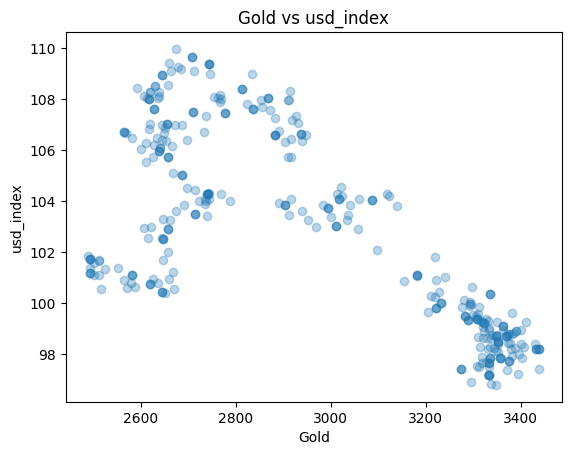

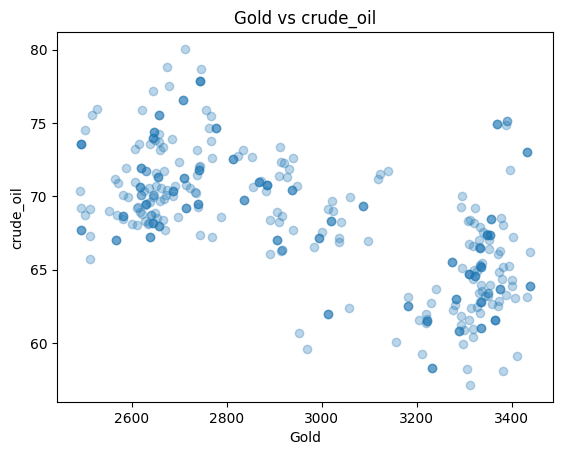

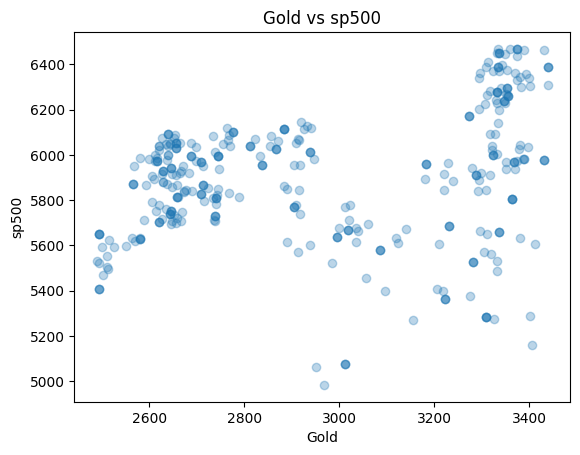

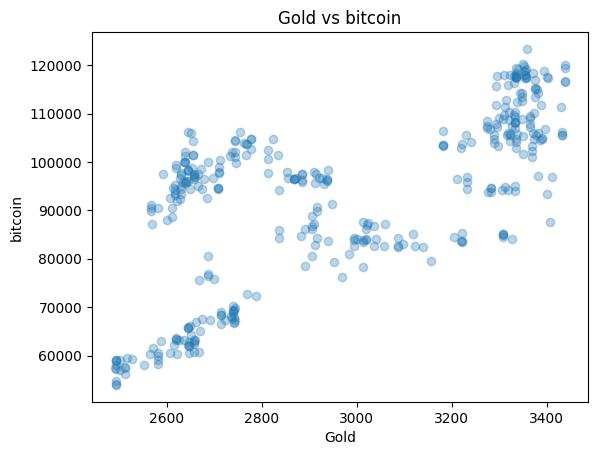

In [171]:
# 5. Simple scatter plots: gold vs each factor
factors = [c for c in df.columns if c not in ["date", "gold"]]

for factor in factors:
    plt.scatter(df["gold"],df[factor],alpha=0.3)
    
    plt.title(f"Gold vs {factor}")
    plt.ylabel(factor)
    plt.xlabel("Gold")
    plt.show()

In [172]:
#linear Regression
df = df.dropna()

# Train/Test Split 
x = df.drop(columns=['date', 'gold'])   # all factors except gold
y = df['gold']                          # gold only - all other factors compared to gold

# Fit Linear Regression 
model = LinearRegression()
model.fit(x, y)

# 5. Predictions & metrics
y_pred = model.predict(x)
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)

# 6. Print results
print("Coefficients:")
print(pd.Series(model.coef_, index=x.columns))
print(f"Intercept: {model.intercept_:.2f}")
print(f"R²: {r2:.3f}, MAE: {mae:.3f}")

plt.tight_layout()
plt.show()

Coefficients:
usd_index   -49.565879
crude_oil     0.831424
sp500        -0.361206
bitcoin       0.013977
dtype: float64
Intercept: 8840.97
R²: 0.876, MAE: 89.756


<Figure size 640x480 with 0 Axes>

In [173]:
# Make sure numeric only
df_numeric = df.drop(columns=['date'])
df_numeric = df_numeric.apply(pd.to_numeric, errors='coerce')
df_numeric = df_numeric.dropna()

# Correlation with gold
corr = df_numeric.corr()['gold'].drop('gold').sort_values(key=abs, ascending=False)

print("Correlation of each feature with gold:")
print(corr)

Correlation of each feature with gold:
usd_index   -0.730250
bitcoin      0.681970
crude_oil   -0.618062
sp500        0.280669
Name: gold, dtype: float64


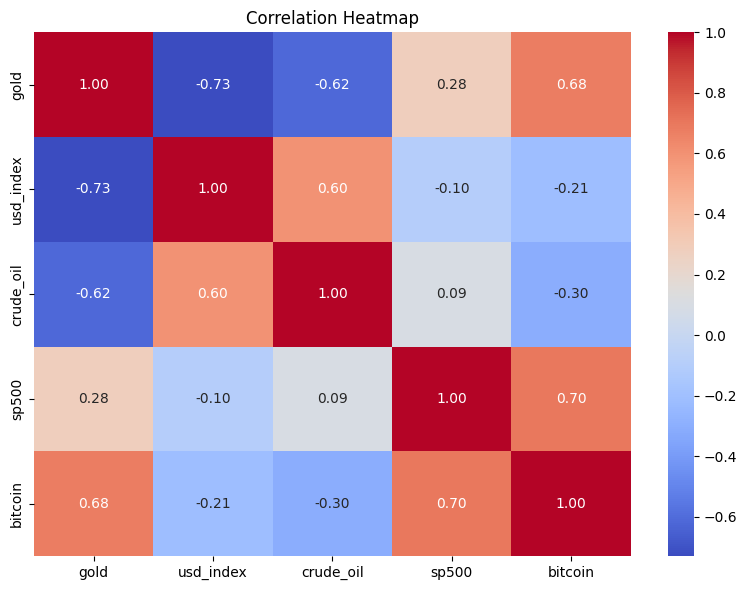

In [174]:
#HEATMAP - visualization of correlation

# 1. Convert to numeric & drop NAs
df_numeric = df.drop(columns=['date'])
df_numeric = df_numeric.apply(pd.to_numeric, errors='coerce').dropna()

# 2. Compute correlation matrix
corr_matrix = df_numeric.corr()

# 3. Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

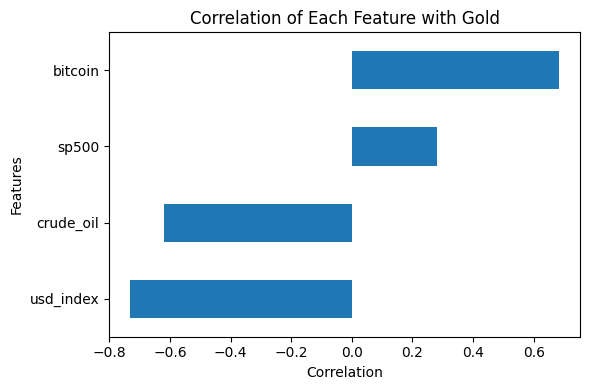

In [175]:
# 1. Numeric only, drop NAs
df_numeric = df.drop(columns=['date'])
df_numeric = df_numeric.apply(pd.to_numeric, errors='coerce').dropna()

# 2. Correlation with gold only
corr_gold = df_numeric.corr()['gold'].drop('gold').sort_values()

# 3. Bar chart
plt.figure(figsize=(6, 4))
corr_gold.plot(kind='barh')
plt.title("Correlation of Each Feature with Gold")
plt.xlabel("Correlation")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

## Forecasting gold price


Evaluation on test set:
                      mae    rmse      r2
LinearRegression  18.5615  25.581  0.5275


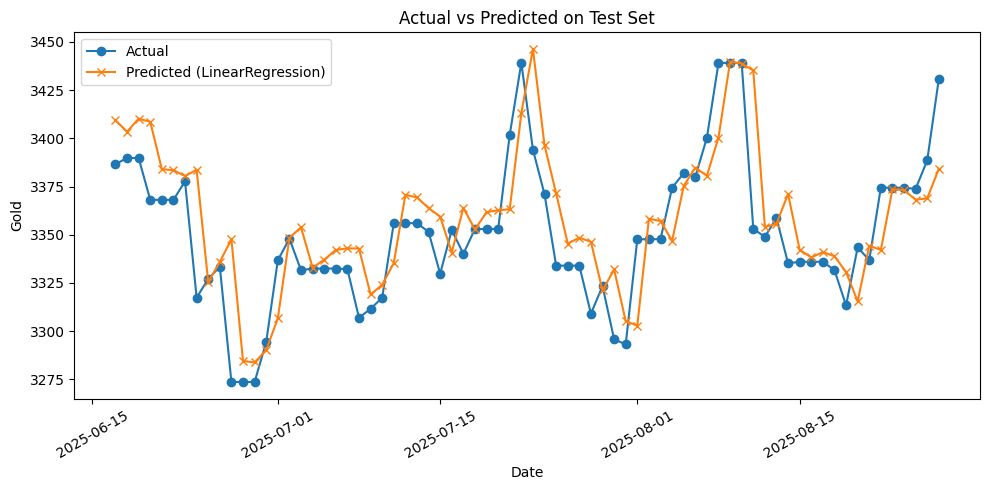

In [189]:
# Copy + drop NaN
df2 = df.copy()
for col in df2.columns:
    if col != "date":
        df2[col] = pd.to_numeric(df2[col], errors="coerce")
df2 = df2.dropna().sort_values("date").reset_index(drop=True)

# config
target = "gold"
exog = [c for c in df2.columns if c not in ("date", target)]
n_lags = 5           # num of lag
test_frac = 0.2      
forecast_horizon = 14 # Days to forcast

# create lag features (autoregressive)
for lag in range(1, n_lags + 1):
    df2[f"gold_lag_{lag}"] = df2[target].shift(lag)

# drop rows with NA lags
df2 = df2.dropna().reset_index(drop=True)

# feature matrix
lag_cols = [f"gold_lag_{lag}" for lag in range(1, n_lags + 1)]
feature_cols = lag_cols + exog   # combine lags + exogenous


models = {
    "LinearRegression": LinearRegression()}

fitted = {}
preds = {}
metrics = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    yhat = model.predict(X_test)
    preds[name] = yhat
    fitted[name] = model
    mae = mean_absolute_error(y_test, yhat)
    rmse = np.sqrt(mean_squared_error(y_test, yhat))
    r2  = r2_score(y_test, yhat)
    metrics[name] = {"mae": mae, "rmse": rmse, "r2": r2}

# show metrics
metrics_df = pd.DataFrame(metrics).T[["mae", "rmse", "r2"]]
print("\nEvaluation on test set:")
print(metrics_df.round(4))

#LAG
plt.figure(figsize=(10,5))
plt.plot(dates_test, y_test, label="Actual", marker="o")
for name, yhat in preds.items():
    plt.plot(dates_test, yhat, label=f"Predicted ({name})", marker="x")
plt.xticks(rotation=30)
plt.xlabel("Date")
plt.ylabel("Gold")
plt.title("Actual vs Predicted on Test Set")
plt.legend()
plt.tight_layout()
plt.show()

In [193]:
# FORECASTING

last_row = df2.iloc[-1].copy()     # most recent row with lag features present
last_exog = last_row[exog].values  # last known exogenous features


forecast_dates = pd.date_range(start=pd.to_datetime(df2["date"].iat[-1]) + pd.Timedelta(days=1), periods=forecast_horizon)
forecast_vals = []

# LAG BUFFERING FOR PREDICTION
lag_buffer = list(df2[target].values[-n_lags:])  

for step in range(forecast_horizon):

    feature_lags = [lag_buffer[-i] for i in range(1, n_lags+1)]

    fv = np.array(feature_lags + list(last_exog)).reshape(1, -1)
    ypred = forecast_model.predict(fv)[0]
    forecast_vals.append(ypred)

    lag_buffer.append(ypred)

# show forecast
fc_df = pd.DataFrame({"date": forecast_dates, "forecast_gold":forecast_vals})
print("\nNaive horizon forecast (exogenous repeated last values):")
print(fc_df)


Naive horizon forecast (exogenous repeated last values):
         date  forecast_gold
0  2025-08-28    3379.019086
1  2025-08-29    3364.202202
2  2025-08-30    3363.967322
3  2025-08-31    3365.557567
4  2025-09-01    3375.423372
5  2025-09-02    3367.073714
6  2025-09-03    3366.743499
7  2025-09-04    3367.073714
8  2025-09-05    3364.532418
9  2025-09-06    3367.073714
10 2025-09-07    3367.073714
11 2025-09-08    3367.073714
12 2025-09-09    3367.073714
13 2025-09-10    3367.073714


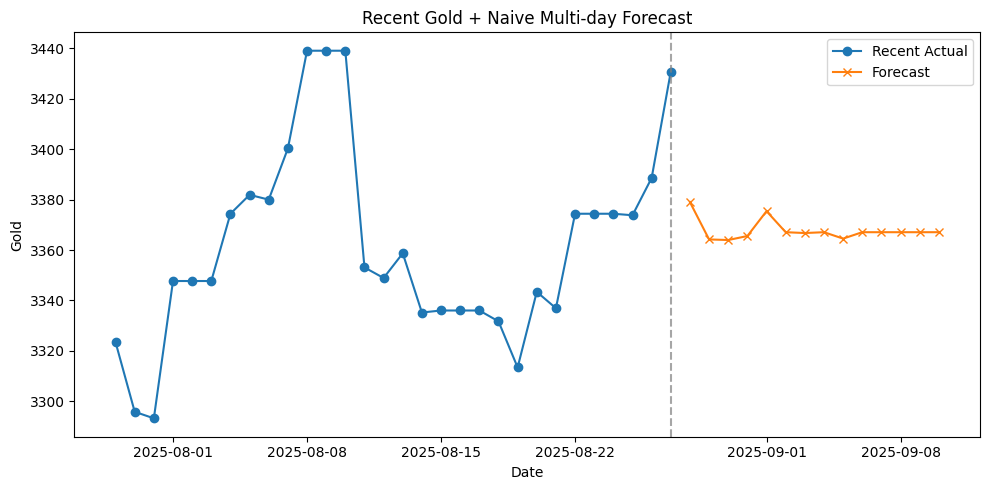

In [186]:
# Plot recent history + forecast
plt.figure(figsize=(10,5))
plt.plot(df2["date"].iloc[-30:], df2[target].iloc[-30:], label="Recent Actual", marker="o")
plt.plot(fc_df["date"], fc_df["forecast_gold"], label="Forecast", marker="x")
plt.axvline(df2["date"].iloc[-1], color="gray", linestyle="--", alpha=0.7)
plt.xlabel("Date"); plt.ylabel("Gold")
plt.title("Recent Gold + Naive Multi-day Forecast")
plt.legend()
plt.tight_layout()
plt.show()